# Frozen Lake - Iterative Policy Evaluation

https://gym.openai.com/envs/FrozenLake-v0/

In [1]:
from frozenlake import FrozenLakeEnv

env = FrozenLakeEnv()

The agent moves through a $4 \times 4$ gridworld, with states numbered as follows:
```
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
```
and the agent has 4 potential actions:
```
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
```

Thus, $\mathcal{S}^+ = \{0, 1, \ldots, 15\}$, and $\mathcal{A} = \{0, 1, 2, 3\}$.

In [2]:
# print the state space and action space
print(env.observation_space)
print(env.action_space)

# print the total number of states and actions
print(env.nS)
print(env.nA)

Discrete(16)
Discrete(4)
16
4


In [3]:
env.P[0]

{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

I have probability, state, reward and is_final_state for all the ACTIONS {0, 1, 2, 3} for every single state.

In [4]:
import numpy as np

def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    while True:
        delta = 0
        for s, state in enumerate(policy):
            v = 0
            for a, action_prob in enumerate(state):
                for next_state_prob, next_state, reward, done in env.P[s][a]:
                    v += action_prob * next_state_prob * ( gamma**(s-1) * V[next_state] + reward)
                                                          
            delta = max(delta, abs(v - V[s]))
            V[s] = v
        if delta < theta:
            return V
            
    return V

In [5]:
random_policy = np.ones([env.nS, env.nA]) / env.nA

In [6]:
from plot_utils import plot_values

# evaluate the policy 
V = policy_evaluation(env, random_policy)

plot_values(V)

<Figure size 600x600 with 1 Axes>

In [7]:
def q_from_v(env, V, s, gamma=1):
    q = np.zeros(env.nA)
    for a in env.P[s]:
        for next_state_prob, next_state, reward, done in env.P[s][a]:
            q[a] += next_state_prob * (reward + gamma * V[next_state])
    
    return q

In [8]:
Q = np.zeros([env.nS, env.nA])
for s in range(env.nS):
    Q[s] = q_from_v(env, V, s)
print("Action-Value Function:")
print(Q)

Action-Value Function:
[[0.0147094  0.01393978 0.01393978 0.01317015]
 [0.00852356 0.01163091 0.0108613  0.01550788]
 [0.02444514 0.02095298 0.02406033 0.01435346]
 [0.01047649 0.01047649 0.00698432 0.01396865]
 [0.02166487 0.01701828 0.01624865 0.01006281]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698432]
 [0.         0.         0.         0.        ]
 [0.01701828 0.04099204 0.03480619 0.04640826]
 [0.07020885 0.11755991 0.10595784 0.05895312]
 [0.18940421 0.17582037 0.16001424 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799677 0.20503718 0.23442716 0.17582037]
 [0.25238823 0.53837051 0.52711478 0.43929118]
 [0.         0.         0.         0.        ]]


In [9]:
def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    
    for s in range(env.nS):
        q = q_from_v(env, V, s)
        policy[s][np.argmax(q)] = 1

    return policy

In [10]:
import copy

def policy_iteration(env, gamma=1, theta=1e-8):
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    V = policy_evaluation(env, policy, gamma, theta)
    policy_new = policy_improvement(env, V, gamma)

    while not np.array_equal(policy, policy_new):
        policy = copy.copy(policy_new)
        V = policy_evaluation(env, policy, gamma, theta)
        policy_new = policy_improvement(env, V, gamma)

    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]] 



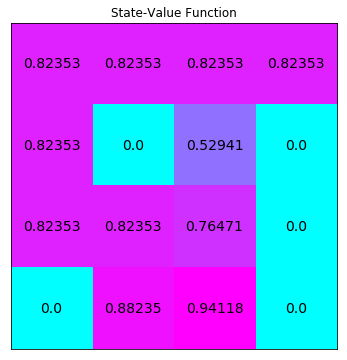

In [11]:
# obtain the optimal policy and optimal state-value function
policy_pi, V_pi = policy_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_pi,"\n")

plot_values(V_pi)

In [12]:
def truncated_policy_evaluation(env, policy, V, max_it=1, gamma=1):
    
    for _ in range(max_it):
        for s, state in enumerate(policy):
            v = 0
            q = q_from_v(env, V, s, gamma)
            for a, action_prob in enumerate(state):
                v += action_prob * q[a]
                                                        
            V[s] = v
    
    return V

In [13]:
def truncated_policy_iteration(env, max_it=1, gamma=1, theta=1e-8):
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    V = np.zeros(env.nS)
    V = truncated_policy_evaluation(env, policy, V, max_it, gamma)
    policy_new = policy_improvement(env, V, gamma)

    while not np.array_equal(policy, policy_new):
        policy = copy.copy(policy_new)
        V = policy_evaluation(env, policy, gamma, theta)
        policy_new = policy_improvement(env, V, gamma)

    
    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]] 



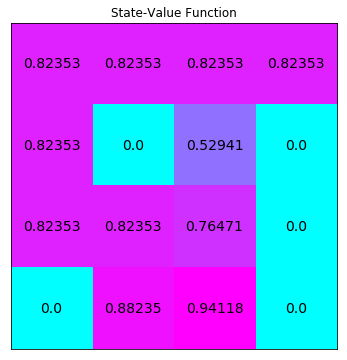

In [14]:
policy_tpi, V_tpi = truncated_policy_iteration(env, max_it=2)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_tpi,"\n")

# plot the optimal state-value function
plot_values(V_tpi)

In [15]:
def value_iteration(env, gamma=1, theta=1e-8):
    V = np.zeros(env.nS)
    policy = np.ones([env.nS, env.nA]) / env.nA
    
    while True:
        delta = 0
        for s, state in enumerate(policy):
            q = q_from_v(env, V, s, gamma)
            v = V[s]
            V[s] = max(q)
            delta = max(delta,abs(V[s]-v))
        if delta < theta:
            break
        
    policy = policy_improvement(env, V, gamma)
        
    
    return policy, V


Optimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]] 



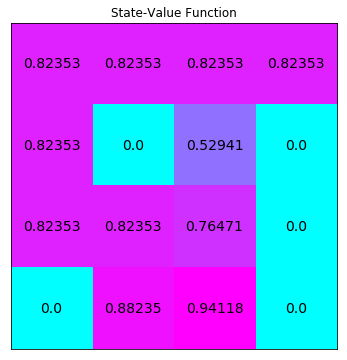

In [16]:
policy_vi, V_vi = value_iteration(env)

# print the optimal policy
print("\nOptimal Policy (LEFT = 0, DOWN = 1, RIGHT = 2, UP = 3):")
print(policy_vi,"\n")

# plot the optimal state-value function
plot_values(V_vi)

In [22]:
def run(env, policy):
    env.reset()
    env.render()
    reward = 0
    step = 0
    while reward == 0:
        next_action = np.argmax(policy[env.s])
        obs, reward, done, info = env.step(next_action)

        step +=1
        print('\nSTEP : ', step)
        env.render()
        if done:
            env.reset()
            break

In [24]:
env = FrozenLakeEnv()
policy, V = value_iteration(env)
run(env, policy)


SFFF
FHFH
FFFH
HFFG

STEP :  1
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  2
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  3
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  4
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  5
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  6
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  7
  (Up)
SFFF
FHFH
FFFH
HFFG

STEP :  8
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  9
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  10
  (Up)
SFFF
FHFH
FFFH
HFFG

STEP :  11
  (Up)
SFFF
FHFH
FFFH
HFFG

STEP :  12
  (Up)
SFFF
FHFH
FFFH
HFFG

STEP :  13
  (Up)
SFFF
FHFH
FFFH
HFFG

STEP :  14
  (Down)
SFFF
FHFH
FFFH
HFFG

STEP :  15
  (Up)
SFFF
FHFH
FFFH
HFFG

STEP :  16
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  17
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  18
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  19
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  20
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  21
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  22
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  23
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  24
  (Left)
SFFF
FHFH
FFFH
HFFG

STEP :  25
  (L

In [25]:
env = FrozenLakeEnv(map_name='8x8')
policy, V = value_iteration(env)
run(env, policy)


SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

STEP :  1
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

STEP :  2
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

STEP :  3
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

STEP :  4
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

STEP :  5
  (Up)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

STEP :  6
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

STEP :  7
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

STEP :  8
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

STEP :  9
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG

STEP :  10
  (Right)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG
